In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
from netCDF4 import Dataset

import cmocean
import pandas as pd
import xarray as xr
import scipy
from scipy.optimize import leastsq
import matplotlib.dates as mdates
import datetime
import dask.array as da
import scipy.ndimage as nd

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

/Users/eavenwatkins/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/eavenwatkins/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
## import functions
from MLD_fxns import *

In [4]:
start = datetime.datetime(2011,8,1)
end = datetime.datetime(2011,10,1)
myFmt = mdates.DateFormatter('%y/%m/%d') # %H:%M')

#lat, lon, u, v, t = get_CODAR(start,end)

beg = datetime.datetime(2006, 1, 1)
d1 = start-beg
d2 = end-beg
d1 = str(24*(d1.days + d1.seconds*60*60*24))
d2 = str(24*(d2.days + d2.seconds*60*60*24))
#print d1, d2
    # Make the URL
url = r'http://tds.marine.rutgers.edu/thredds/dodsC/cool/codar/totals/'
url2 = r'5Mhz_6km_realtime_fmrc/Maracoos_5MHz_6km_Totals-FMRC_best.ncd?'
gridurl = r'lon[0:1:154],lat[0:1:184]'
timeurl = r',time[{}:1:{}]'.format(d1, d2)
uurl = r',u[{}:1:{}][0:1:184][0:1:154]'.format(d1, d2)
vurl = r',v[{}:1:{}][0:1:184][0:1:154]'.format(d1, d2)

furl = url + url2 + gridurl + timeurl + uurl + vurl
    # The dataset from OpenDAP
data   = xr.open_dataset(furl)#, chunks={'time': 1000})
#aaaa   = Dataset(furl)

In [5]:
    # Get variables
lon = data.lon
lat = data.lat
u = data.u
v = data.v
t = data.time

t_vec = mdates.date2num(t)

In [6]:
i_lat = 110
j_lon = 75
lat_get = float(data.lat[i_lat])
lon_get = float(data.lon[j_lon])

print(lat_get, lon_get)

39.48221969604492 -72.62113952636719


In [7]:
%%time
uu = np.nan_to_num(u[:,i_lat,j_lon])
vv = np.nan_to_num(v[:,i_lat,j_lon])

CPU times: user 13.7 ms, sys: 5.47 ms, total: 19.1 ms
Wall time: 13.7 s


In [8]:
lat = lat_get
f_sec = coriolis_frequency(lat_get)
f_hr = 3600*f_sec
Fday = 24*f_hr

In [14]:
#vwind_loc = '/Users/cew145/Downloads/Vwind_nam_3hourly_MAB_and_GoM_2011.nc' # laptop
#uwind_loc = '/Users/cew145/Downloads/Uwind_nam_3hourly_MAB_and_GoM_2011.nc' # laptop

#vwind_loc = '/Users/eavenwatkins/Documents/MLD_data/Vwind_nam_3hourly_MAB_and_GoM_2011.nc'
#uwind_loc = '/Users/eavenwatkins/Documents/MLD_data/Uwind_nam_3hourly_MAB_and_GoM_2011.nc'

year = 2011
thredds  = 'http://tds.marine.rutgers.edu/thredds/dodsC'
vwind_loc = thredds+'/met/ncdc-nam-3hour/Vwind_nam_3hourly_MAB_and_GoM_{}.nc'.format(str(year))
uwind_loc = thredds+'/met/ncdc-nam-3hour/Uwind_nam_3hourly_MAB_and_GoM_{}.nc'.format(str(year))

#vwind_loc = '/Users/cewatkin/Downloads/Vwind_nam_3hourly_MAB_and_GoM_2011.nc' # desktop
#uwind_loc = '/Users/cewatkin/Downloads/Uwind_nam_3hourly_MAB_and_GoM_2011.nc' # desktop

In [15]:
vwind_data = xr.open_dataset(vwind_loc)

In [16]:
uwind_data = xr.open_dataset(uwind_loc)

In [17]:
Vwind = vwind_data.Vwind
Uwind = uwind_data.Uwind
Twind = uwind_data.time
Ywind = uwind_data.lat
Xwind = uwind_data.lon

In [18]:
Twind = mdates.date2num(Twind)
deltaTwind = float(Twind[-1] - Twind[0])
dTwind = float(Twind[1] - Twind[0])

In [19]:
z=10
filtL = lanczos(41,63)
c = np.e/8

def slab_ocean_response(z, W, time, f, c):
    length = time.shape[0]
    Vi = 0.001 + 1j*(0.001)
    dt = time[1]-time[0]
    try:
        del data[:]
    except:
        data = np.ones(length,dtype='complex')
    data[0] = Vi
    for i in range(length-1):
        dVR = np.sum(rk4_Pollard_1d(data[i],dt,W[i],Zo=10,f=f,c=c));
        Vn  = data[i] + dVR # #rk4[i]
        data[i+1] = Vn
    #v_in = bandpass_fir_CODAR(V.imag, time, 18.2, 19.0)
    #u_in = bandpass_fir_CODAR(V.real, time, 18.2, 19.0)
    #Vamp_in = np.abs(data)
    return data

In [20]:
import scipy.optimize as optim

def fractional_rolls(Q,k,roll,t,y):
    dx = t[1]-t[0]
    qmin, qmax = np.nanmin(Q), np.nanmax(Q)
    guess = y[qmin-100:qmax+101]
    xg = t[qmin-100:qmax+101] - t[k]
    ypoly = np.polyfit(xg, guess, 20)
    p = np.poly1d(ypoly)
    g2 = p(xg+roll*dx)
    return g2[100:-100]

def error_function2D(x,k,t,observed,calculated):
    rmax = 36*(t[1]-t[0])
    r = np.abs((t-t[k])/rmax);
    Q = np.where(np.greater_equal(1,r));
    r = r[Q]
    twin = t[Q]
    w = (1-r**3)**3
    #rolled_calc = shift_signal_in_frequency_domain(calculated,10*x[1])
    rolled_calc = fractional_rolls(Q,k,36*x[1],t,calculated)
    #rolled_calc = np.roll(calculated,np.int(np.nan_to_num(100*x[1])))
    w_roll = 1+abs(x[1])**4
    return np.sum(np.abs(rolled_calc/x[0] - observed[Q])*w*100)*w_roll

In [21]:
buffer = 7*24 
dates = np.arange(buffer,len(t_vec)-buffer,6)
z0_data = np.zeros(len(dates))
phase_data = np.ones_like(z0_data)
t_data = np.ones_like(z0_data)

In [22]:
import multiprocessing

def parallel_2D_error(k, time, obs, calc):
    bnds = ((20, 300),(-1,1))
    vectorized_error = lambda x: error_function2D(x,k,time,observed=obs,calculated=calc) 
    x_init = np.random.uniform(low=bnds[0][0], high=bnds[0][1])
    y_init = np.random.uniform(low=bnds[1][0], high=bnds[1][1])
    res = optim.minimize(vectorized_error,[x_init, y_init], method='TNC', bounds=bnds)
    return time[k], res.x[0], res.x[1]

#def vect2D(k, time=t_vec, obs=obs, calc=calc):
#    return parallel_2D_error(k, time, obs, calc)

In [23]:
cores = multiprocessing.cpu_count()-1
print(cores)

def parallel_error_fxn(k, time, obs, calc):
    bump=5
    bnds = ((1./50., 500),(-0.9,0.9))
    #k,time,obs,calc = K[0],K[1],K[2],K[3]
    vectorized_error = lambda x: error_function(x,k,time,obs,calc) 
    mldtemp = np.ones(bump)
    phasetemp = np.ones(bump)
    residtemp = np.ones(bump)
    for i in range(bump):
        x_init = np.random.uniform(low=bnds[0][0], high=bnds[0][1])
        y_init = np.random.uniform(low=bnds[1][0], high=bnds[1][1])
        res = optim.minimize(vectorized_error,[x_init, y_init], method='TNC', bounds=bnds)
        mldtemp[i]   = res.x[0]
        phasetemp[i] = res.x[1]
        residtemp[i] = res.fun
    mindex = np.where(residtemp == np.nanmin(residtemp))[0][0]
    return  time[k], mldtemp[mindex], phasetemp[mindex]

3


## Make a map

In [24]:
bathurl = 'http://tds.marine.rutgers.edu/thredds/dodsC/other/bathymetry/w100w20s10n90.nc?lat[0:1:11999],lon[0:1:9599],elevation[0:1:11999][0:1:9599]'
bathdata = Dataset(bathurl, mode='r')
blat = bathdata.variables['lat']
blon = bathdata.variables['lon']
bath = bathdata.variables['elevation']

In [25]:
u_time_size = np.shape(u[:,0,0])[0]
date_get = dates

In [30]:
### Build domain variables
latsize = len(data.lat)
lonsize = len(data.lon)

i_lat = np.arange(0,latsize,1)
j_lon = np.arange(0,lonsize,1)

size = len(i_lat)*len(j_lon)*len(date_get)

z0_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
phase_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
t_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
c_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
wi_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
wr_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))

In [31]:
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

In [32]:
nannums = np.zeros((len(i_lat), len(j_lon)))
cores = cores - 1

def getnans(position, variable):
    lat_index, lon_index = position[0], position[1]
    u_comp   = variable[:,lat_index,lon_index]
    nantotal = np.sum(np.isnan(u_comp))
    return 100*np.true_divide(nantotal,u_time_size)

def vectnans(position, variable=u):
    return getnans(k, variable)
     
positions = []

for m, lon_index in enumerate(j_lon):
    for n, lat_index in enumerate(i_lat):
        positions.append([n,m])
        
velshape = u.shape

In [33]:
u_np = np.ones(velshape)
for i in range(velshape[0]):
    u_np[i,:,:] = u[i,:,:]

In [34]:
v_np = np.ones(velshape)
for i in range(velshape[0]):
    v_np[i,:,:] = v[i,:,:]

In [35]:
nannums = np.apply_along_axis(lambda m: 100*np.sum(np.isnan(m))/float(m.shape[0]), axis=0, arr=u_np)
uclean = np.apply_along_axis(lambda m: np.nan_to_num(m), axis=0, arr=u_np)
vclean = np.apply_along_axis(lambda m: np.nan_to_num(m), axis=0, arr=v_np)

In [36]:
def slab_inertial(location,Vwind,Uwind,Twind,Xwind,Ywind,Tcodar):
    "return the slab inertial amplitude for a given location"
    # WRF Wind data for nearest point
    lon_get = location[0] 
    lat_get = location[1]
    distance_codar_sqr = np.array((Xwind-lon_get)**2 + (Ywind-lat_get)**2)
    kx, ky = np.where(distance_codar_sqr == np.nanmin(distance_codar_sqr))
    kx = int(kx); ky = int(ky)

    ## Format the data
    data_y = 3600*Vwind[:,ky,kx]
    data_x = 3600*Uwind[:,ky,kx]
    Wind_u = np.interp(t_vec, Twind, data_x)
    Wind_v = np.interp(t_vec, Twind, data_y)

    ## Coriolis for the lat
    f_sec = coriolis_frequency(lat_get)
    Fday = f_sec*60*60*24
    T_in = inertial_period(lat_get)/24.0
    low, high = 0.9*T_in, 1.1*T_in
    filt  = lanczos(int(np.ceil(48*T_in)),2*int(np.ceil(36*T_in))+1)

    ## Put wind into complex format
    WIND = Wind_u - 1j*Wind_v
    v_slab = slab_ocean_response(10,WIND,Tcodar,Fday,np.e/8)
    amp_slab = nd.maximum_filter(abs(v_slab),8)
    return np.abs(np.convolve(amp_slab,filtL,'same'))

def codar_inertial(uCodar,vCodar,latitude,Tcodar):
    T_in = inertial_period(latitude)/24.0
    low, high = 0.9*T_in, 1.1*T_in
    filt  = lanczos(int(np.ceil(48*T_in)),2*int(np.ceil(36*T_in))+1)

    vv_in = bandpass_fir_CODAR(vCodar, Tcodar, low, high)
    uu_in = bandpass_fir_CODAR(uCodar, Tcodar, low, high)
    VV_in = np.abs(uu_in + 1j*vv_in)
    VVamp_filt = nd.maximum_filter(abs(VV_in),8)
    return np.abs(np.convolve(VVamp_filt,filtL,'same'))

In [37]:
lonCODAR = data.lon
latCODAR = data.lat

t_data = t_vec[date_get]

In [41]:
cores = 4

In [ ]:
# Working for-loop
p = multiprocessing.Pool(cores)

iterator = 0
now = datetime.datetime.now()
for m, Jlon in enumerate(j_lon):
    for n, Ilat in enumerate(i_lat):
        if nannums[Ilat,Jlon] > 10:
            z0_data[n,m,:]    = np.nan
            phase_data[n,m,:] = np.nan
            c_data[n,m,:]     = np.nan
            wi_data[n,m,:]    = np.nan
            wr_data[n,m,:]    = np.nan
        
        else:
            iterator += 1
            u_comp = uclean[:,Ilat,Jlon]
            v_comp = vclean[:,Ilat,Jlon]
            lat_get = np.round(float(latCODAR[Ilat]),3)
            lon_get = np.round(float(lonCODAR[Jlon]),3)
            
            timeprocess = datetime.datetime.now() - now
            speed = np.round(timeprocess.total_seconds()/float(iterator),2)
            clear_output()
            display("Working on MLD at lat,lon = {},{}, at {} $s/p_{}$".format(lat_get, lon_get, speed,
                                                                               '{'+str(iterator)+'}'))

            
            calc = slab_inertial([lon_get,lat_get],Vwind,Uwind,Twind,Xwind,Ywind,t_vec)
            obs  = codar_inertial(u_comp,v_comp,lat_get,t_vec)
            
            def vect_in_loop(k, time=t_vec, obs=obs, calc=calc):
                return parallel_2D_error(k, time, obs, calc)

            c_data[n,m,:] = obs[date_get]
            #wi_data[n,m,:]= np.abs(WIND[date_get])
            wr_data[n,m,:]= calc[date_get]
            p = multiprocessing.Pool(cores)
            for k, result in enumerate(p.imap(vect_in_loop, dates)):
                z0_data[n,m,k]    = result[1]
                phase_data[n,m,k] = result[2]
            #p.close()

p.close()
display("done")

'Working on MLD at lat,lon = 40.615,-72.737, at 23.29 $s/p_{2619}$'

In [ ]:
p.close()

In [11]:
#  Find the depth from bathymetry
#findlat = np.abs(blat[:] - lat_get)
#findlon = np.abs(blon[:] - lon_get)
#bathlat =  np.where(findlat == np.min(findlat))[0][0]
#bathlon =  np.where(findlon == np.min(findlon))[0][0]
#D = abs(bath[bathlat,bathlon])
#clist = c_frombath(D,zlist,eps12h,eps96h)
#clist = c_bath_parabola(D,zlist,eps12h,eps96h,20.0)

In [12]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.gridspec as gridspec # GRIDSPEC !
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

NameError: name 'lonCODAR' is not defined

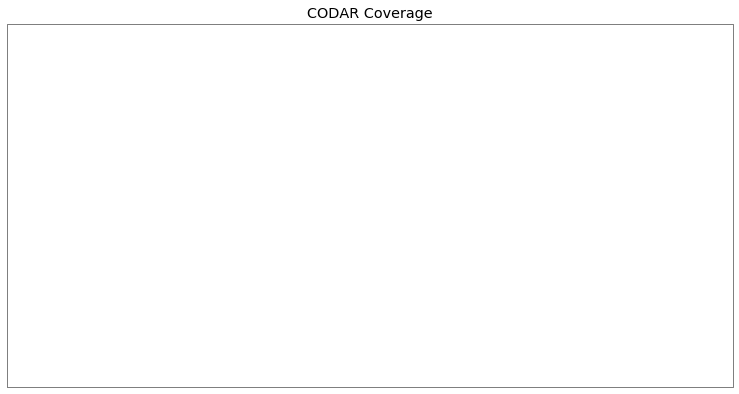

In [13]:
fig = plt.figure(1, figsize=(13,9))

ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('CODAR Coverage')
kw = dict(levels=np.linspace(0,100,51), cmap=cmocean.cm.dense ,transform=ccrs.PlateCarree())
plt.contourf(lonCODAR, latCODAR, nannums, **kw)
ax.coastlines(resolution='50m', color='white', linewidth=1.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')

plt.colorbar(ticks=np.arange(0,101,10),label='Percent NaN')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


plt.show()

In [102]:
X, Y = np.meshgrid(lonCODAR[j_lon], latCODAR[i_lat])

In [105]:
mld_filt = np.apply_along_axis(lambda m: scipy.signal.medfilt(m,5), axis=2, arr=z0_data)

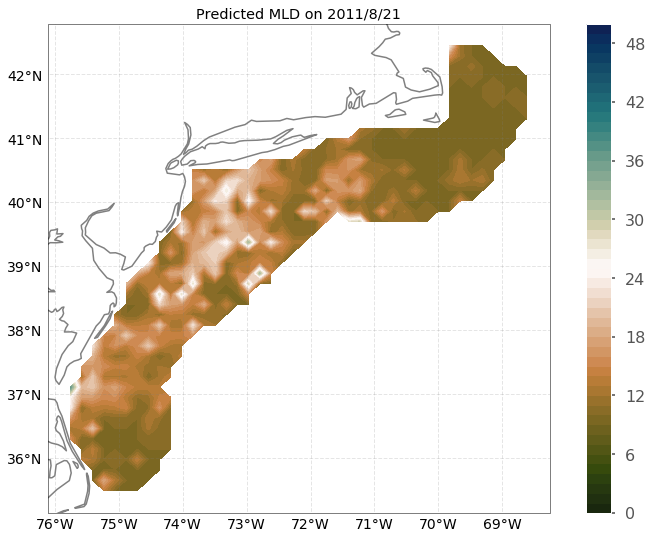

In [109]:
ik = 40
ikdate = mdates.num2date(t_data[ik])

fig = plt.figure(1, figsize=(13,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('Predicted MLD on {}/{}/{}'.format(ikdate.year,ikdate.month,ikdate.day))
kw = dict(levels=np.linspace(0,50,51), cmap=cmocean.cm.tarn ,transform=ccrs.PlateCarree())
plt.contourf(X,Y,mld_filt[:,:,ik]/2, **kw)
ax.coastlines(resolution='50m', color='gray', linewidth=1.5)

plt.colorbar()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.show()

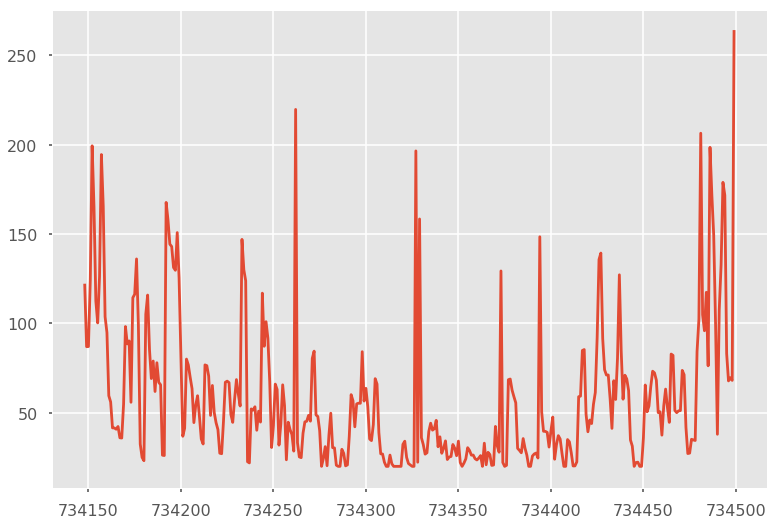

In [64]:
#plt.plot(c_data[24,20,:])
#plt.plot(wr_data[24,20,:]/25)

plt.plot(t_data,z0_data[24,20,:])

In [113]:
%%time
u_comp = u[:,lat_index,j_lon[n]]
nantotal = int(np.sum(np.isnan(u_comp)))

IndexError: index 36 is out of bounds for axis 0 with size 31

In [75]:
100*np.true_divide(nantotal,u_time_size)

24.529163337518547

<xarray.DataArray 'u' ()>
array(2149)
Coordinates:
    lon      float32 -74.6538
    lat      float32 35.7064
    time     datetime64[ns] 2012-01-04